In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
#import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

#from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
#import mitequinox.sigp as sp




In [2]:
#Load data
path = '/Users/zcaspar/codes/mit4320/'
dsL = xr.open_dataset(path+'binned_Lcov_uu_dl2_new.nc') # Lagrangian SSU, 2° bins
dsL_flag = xr.open_dataset(path+'binned_Lcov_uu_dl2_flag.nc') # Lagrangian SSU, 2° bins, without flagged depth
dsE = xr.open_dataset(path+'binned_Ecov_dl2.nc') # Eulerian SSU, 2° bins
dsE_low = xr.open_dataset(path+'binned_Ecov_low_dl2.nc') # Eulerian SSU, bf, 2° bins

dsL_dl1 = xr.open_dataset(path+'binned_Lcov_dl1.nc') # Lagrangian SSU, 1° bins
dsE_dl1 = xr.open_dataset(path+'binned_Ecov_dl1.nc') # Eulerian SSU, 1° bins

dsL_vv = xr.open_dataset(path+'binned_Lcov_vv.nc') # Lagrangian SSV, 2° bins
dsE_vv = xr.open_dataset(path+'binned_Ecov_vv_dl2.nc') # Eulerian SSV, 2° bins


#SSUV spectra
E_SSUV = xr.open_dataset(path+'/E_SSUV.nc') #Eulerian
L_SSUV = xr.open_dataset(path+'/L_SSUV.nc') #Lagrangian

In [3]:
# Subsampling Lagrangian data to  match Eulerian dataset
dsL = dsL.isel(lags=slice(0,None,3)).sel(lon_bins=dsE.lon_bins,lat_bins=dsE.lat_bins,method='nearest')#.sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))
dsL_flag = dsL_flag.isel(lags=slice(0,None,3)).sel(lon_bins=dsE.lon_bins,lat_bins=dsE.lat_bins,method='nearest')#.sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))

In [4]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator

In [5]:
dsE = dsE.where(dsE.rr!=0) # change 0 to nan (corresponding to land)
dsE_vv = dsE_vv.where(dsE_vv.rr!=0) # change 0 to nan (corresponding to land)
dsE_low = dsE_low.where(dsE_low.rr!=0) # change 0 to nan (corresponding to land)
dsE_dl1 = dsE_dl1.where(dsE_dl1.rr!=0)

In [9]:
dsL = dsL.interp({'lon_bins':dsE.lon_bins})
dsL_flag = dsL_flag.interp({'lon_bins':dsE.lon_bins})

Text(0.5, 1.0, 'Variance ratio')

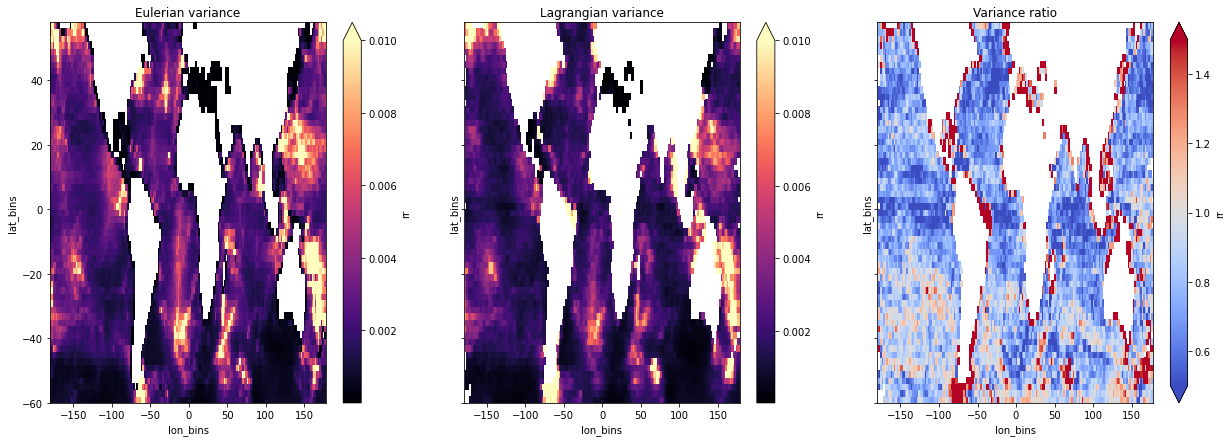

In [16]:
cmap ='magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
#(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.1,ax=axs[2])
(dsL['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).plot(cmap='coolwarm',vmax=1.5,y='lat_bins',vmin=0.5,ax=axs[2])
axs[2].set_title('Variance ratio')

#for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]:
#    axs[0].scatter(bbox[0],bbox[1],c='g')
#    axs[1].scatter(bbox[0],bbox[1],c='g')
#    axs[2].scatter(bbox[0],bbox[1],c='g')
#plt.show()

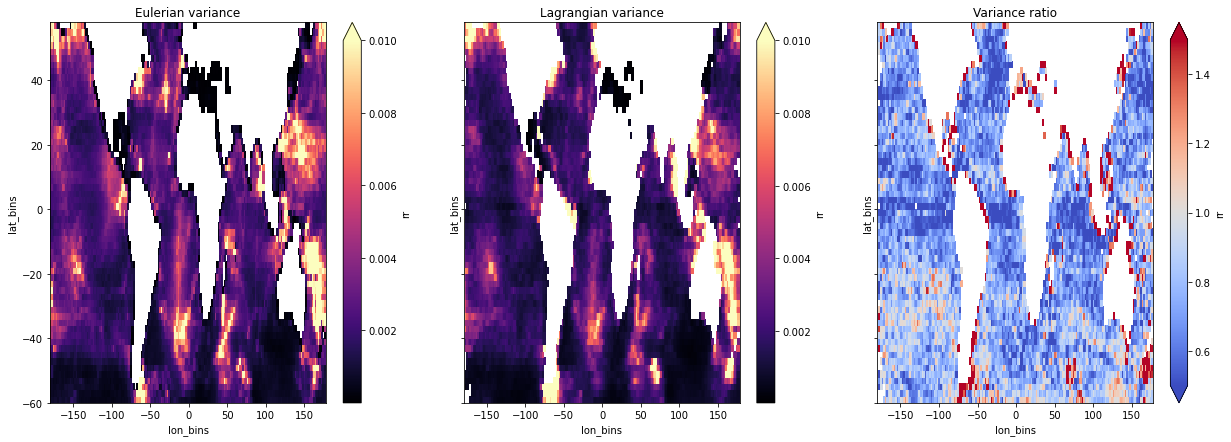

In [19]:
cmap ='magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
#(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.1,ax=axs[2])
(dsL_flag['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).plot(cmap='coolwarm',vmax=1.5,y='lat_bins',vmin=0.5,ax=axs[2])
axs[2].set_title('Variance ratio')
plt.show()
fig.savefig('/Users/zcaspar/codes/mit4320/var_maps.png')

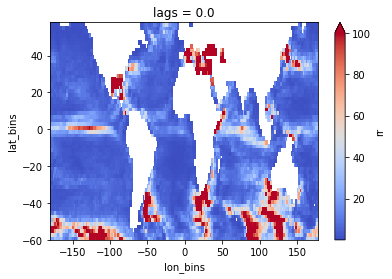

In [23]:
(dsE_low['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).plot(cmap='coolwarm',y='lat_bins',vmax=100)

In [30]:
dsE.mean(['lat_bins','lon_bins'])/dsE.mean(['lat_bins','lon_bins']).isel(lags=0)

<xarray.Dataset>
Dimensions:  (lags: 321)
Coordinates:
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr       (lags) float64 1.0 0.9991 0.9965 0.9923 ... -0.2474 -0.256 -0.2644
    ri       (lags) float64 1.0 -3.163 -7.317 -11.45 ... -58.53 -57.45 -56.34
    count    (lags) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

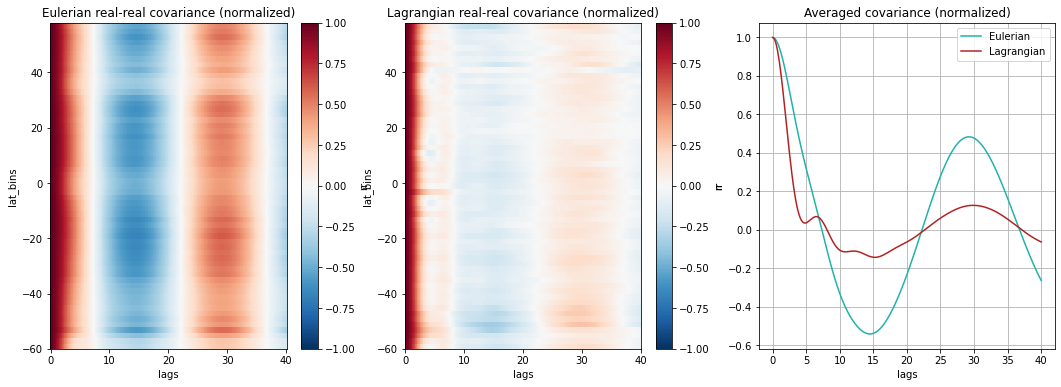

In [39]:
ce,cl = 'lightseagreen','firebrick'
fig,axs = plt.subplots(1,3,figsize=(18,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
#(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsL_flag.mean('lon_bins')/dsL_flag.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsE.mean(['lat_bins','lon_bins'])/dsE.mean(['lat_bins','lon_bins']
                                           ).isel(lags=0)).rr.plot(c=ce,ax=axs[2],label='Eulerian')
(dsL_flag.mean(['lat_bins','lon_bins'])/dsL_flag.mean(['lat_bins','lon_bins']
                                                     ).isel(lags=0)).rr.plot(c=cl,ax=axs[2],label='Lagrangian')
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')
axs[2].set_title('Averaged covariance (normalized)')
axs[2].grid();axs[2].legend()
#axs[2].set_title('Lagrangian real-real covariance (normalized) : coastal area removed')
fig.savefig('/Users/zcaspar/codes/mit4320/autocov.pdf')

Text(0.5, 1.0, 'Lagrangian real-imag covariance : coastal area removed')

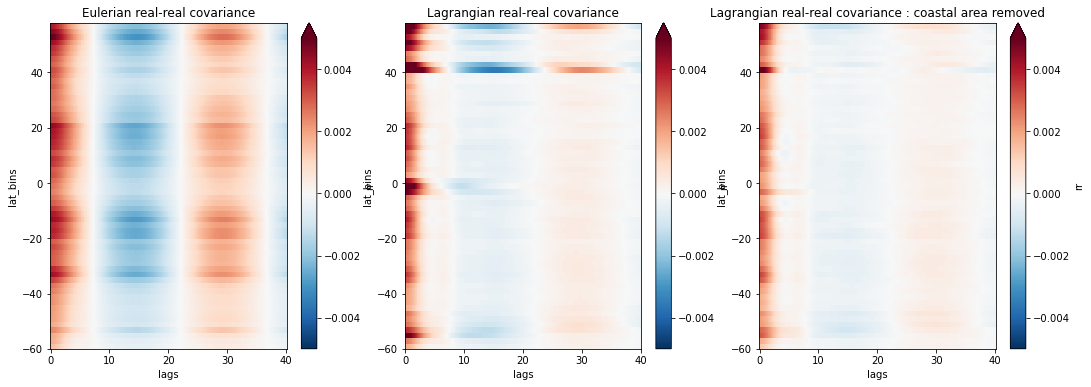

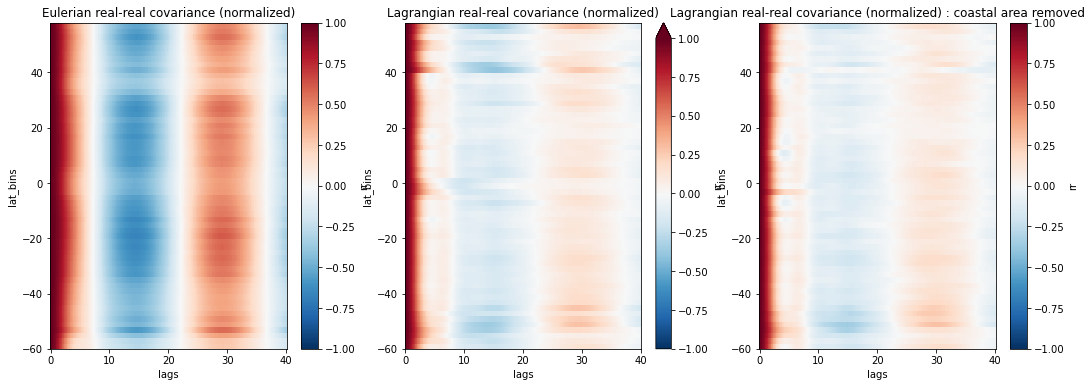

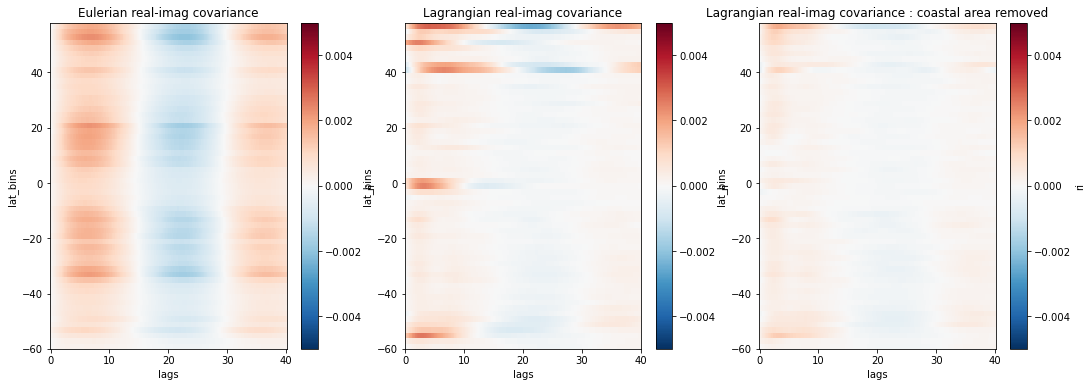

In [24]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
dsE.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
dsL_flag.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[2],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[2].set_title('Lagrangian real-real covariance : coastal area removed')

fig,axs = plt.subplots(1,3,figsize=(18,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsL_flag.mean('lon_bins')/dsL_flag.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[2],vmax=1)
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')
axs[2].set_title('Lagrangian real-real covariance (normalized) : coastal area removed')

fig,axs = plt.subplots(1,3,figsize=(18,6))
dsE.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[1],vmax=0.005)
dsL_flag.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[2],vmax=0.005)
axs[0].set_title('Eulerian real-imag covariance')
axs[1].set_title('Lagrangian real-imag covariance')
axs[2].set_title('Lagrangian real-imag covariance : coastal area removed')